# Ungraded Lab: Training a Sarcasm Detection Model using Bidirectional LSTMs

In this lab, you will revisit the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) dataset and use it to train a Bi-LSTM Model.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Load the Dataset

First, you will download the JSON file and extract the contents into lists.

In [ ]:
import os
try:
    import wget
except ModuleNotFoundError:
    print("Installing wget module...")
    !pip install wget
    import wget

def download_dataset(url, folder, filename):
    # Check if the folder exists, otherwise, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_path = os.path.join(folder, filename)

    # Check if the file has already been downloaded
    if not os.path.exists(file_path):
        print(f"Downloading file from {url}...")
        wget.download(url, out=folder)
        print("\nDownload completed.")
    else:
        print("The file has already been downloaded.")

# Specify the URL of the file, the destination folder, and the filename
url = "https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json"
folder = "Datasets"
filename = "sarcasm.json"

# Call the function to download the file.
download_dataset(url, folder, filename)

Installing wget module...
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=08a43e5a0a51dc48442cfe8356b2482faf483a6d396cbc950c009d8509ae1312
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget

Download completed.


In [ ]:
import json

def load_json_file(file_path):
    # Load the JSON file
    with open(file_path, 'r') as f:
        json_data = json.load(f)
    return json_data

# Example usage
datastore = load_json_file("./Datasets/sarcasm.json")

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Parameters

We placed the constant parameters in the cell below so you can easily tweak it later:

In [ ]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Type of padding
PADDING_TYPE = 'pre'

# Specifies how to truncate the sequences
TRUNC_TYPE = 'post'

## Split the Dataset

You will then split the lists into train and test sets.

In [ ]:
# Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

## Data preprocessing

Next, you will generate the vocabulary and padded sequences. You will combine the sentences and labels, then put them in a `tf.data.Dataset`. This will let you leverage the `tf.data` pipeline methods you've been using to preprocess the dataset.

In [ ]:
import tensorflow as tf

def prepare_datasets(train_sentences, train_labels, test_sentences, test_labels, vocab_size):
    """
    Prepares TensorFlow datasets and a TextVectorization layer for text processing.

    Args:
        train_sentences (list): List of training sentences.
        train_labels (list): Corresponding labels for the training sentences.
        test_sentences (list): List of testing sentences.
        test_labels (list): Corresponding labels for the testing sentences.
        vocab_size (int): Maximum size of the vocabulary for the vectorization layer.

    Returns:
        tuple: A tuple containing the TextVectorization layer, training dataset, and testing dataset.
    """
    # Instantiate the vectorization layer
    vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

    # Generate the vocabulary based on the training inputs
    vectorize_layer.adapt(train_sentences)

    # Create TensorFlow datasets from sentences and labels
    train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

    return vectorize_layer, train_dataset, test_dataset

vectorize_layer, train_dataset, test_dataset = prepare_datasets(train_sentences, train_labels, test_sentences, test_labels, VOCAB_SIZE)


You will use the same preprocessing function from the previous lab to generate the padded sequences.

In [ ]:
def preprocessing_fn(dataset):
    """
    Generates padded sequences from a tf.data.Dataset

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset containing text features and labels.

    Returns:
        tf.data.Dataset: A TensorFlow dataset containing padded sequences paired with their labels.
    """

    # Apply the vectorization layer to the string features
    dataset_sequences = dataset.map(
        lambda text, label: (vectorize_layer(text), label)
        )

    # Put all elements in a single ragged batch
    dataset_sequences = dataset_sequences.ragged_batch(
        batch_size=dataset_sequences.cardinality()
        )

    # Output a tensor from the single batch. Extract the sequences and labels.
    sequences, labels = dataset_sequences.get_single_element()

    # Pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(
        sequences.numpy(),
        maxlen=MAX_LENGTH,
        truncating=TRUNC_TYPE,
        padding=PADDING_TYPE
        )

    # Convert back to a tf.data.Dataset
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    labels = tf.data.Dataset.from_tensor_slices(labels)

    # Combine the padded sequences and labels
    dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

    return dataset_vectorized

In [ ]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

It's always good to check a few examples to see if the transformation works as expected.

In [ ]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print('='*80)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  319,    1,
        943, 4079, 2366,   47,  366,   94, 2026,    6, 2653, 9470],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    4, 7185, 3128, 3305,
         28,    2,  152,    1,  358, 2902,    6,  236,    9,  844],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


Then, you will optimize and batch the dataset.

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

def optimize_dataset(dataset_vectorized, shuffle=False):
    '''
    Optimizes the dataset for training.

    Args:
        dataset_vectorized (tf.data.Dataset): Dataset containing the vectorized data.
        shuffle (bool): Indicates whether to shuffle the dataset or not. Default is False.

    Returns:
        tf.data.Dataset: Optimized dataset with caching, prefetching, and batching applied.
    '''
    dataset_final = dataset_vectorized.cache()
    dataset_final = dataset_final.shuffle(SHUFFLE_BUFFER_SIZE) if shuffle else dataset_final
    dataset_final = dataset_final.prefetch(buffer_size=PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset_final

train_dataset_final = optimize_dataset(train_dataset_vectorized, shuffle=True)
test_dataset_final = optimize_dataset(test_dataset_vectorized)

## Plot Utility

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_loss_history(history):
    """
    Plots training and validation metrics (accuracy and loss) over epochs in subplots.

    Args:
        history (History): History object returned by the fit method of a Keras model.

    Returns:
        None: Displays a figure with two subplots for accuracy and loss.
    """
    metrics = ['accuracy', 'loss']

    # Create a figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    for i, metric in enumerate(metrics):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history[f'val_{metric}'])
        axs[i].set_title(f'TRAINING AND VALIDATION {metric.upper()}')
        axs[i].set_xlabel("Epochs")
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend([metric, f'val_{metric}'])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

## Build and Compile the Model

The architecture here is almost identical to the one you used in the previous lab with the IMDB Reviews. Try to tweak the parameters and see how it affects the training time and accuracy (both training and validation).

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

class LSTMModel:
    def __init__(self, max_length, vocab_size, embedding_dim, lstm_dim, dense_dim):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_dim = lstm_dim
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(self.max_length,)),
            Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim),
            Bidirectional(LSTM(self.lstm_dim)),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [ ]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 24

# Create an instance of the SentimentModel class
lstm_model = LSTMModel(MAX_LENGTH, VOCAB_SIZE, EMBEDDING_DIM, LSTM_DIM, DENSE_DIM)

# Print the summary
lstm_model.summary()

# Compile the model
lstm_model.compile_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,129 (680.19 KB)

 Trainable params: 174,129 (680.19 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
NUM_EPOCHS = 10

lstm_history = lstm_model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.6991 - loss: 0.5403 - val_accuracy: 0.8509 - val_loss: 0.3471
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.8954 - loss: 0.2596 - val_accuracy: 0.8517 - val_loss: 0.3732
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9315 - loss: 0.1823 - val_accuracy: 0.8453 - val_loss: 0.4564
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.9564 - loss: 0.1298 - val_accuracy: 0.8411 - val_loss: 0.5298
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9720 - loss: 0.0872 - val_accuracy: 0.8390 - val_loss: 0.6564
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9827 - loss: 0.0577 - val_accuracy: 0.8380 - val_loss: 0.7795
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9884 - loss: 0.0369 - val_accuracy: 0.8329 - val_loss: 0.8445
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9933 - loss: 0.0228 - 

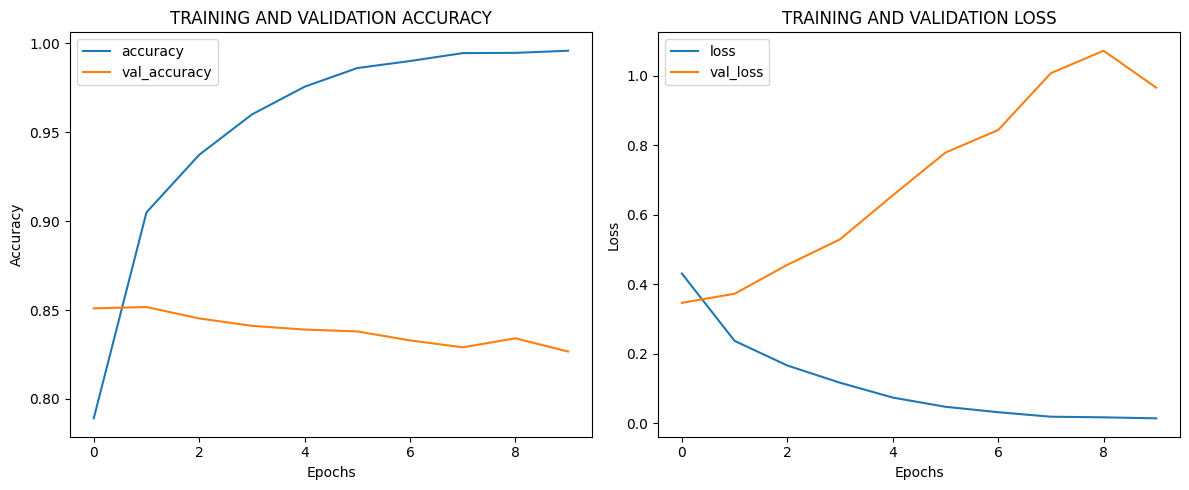

In [ ]:
# Plot the accuracy and loss history
plot_accuracy_loss_history(lstm_history)

## Wrap Up

This concludes this lab on using LSTMs for the Sarcasm dataset. You will explore another architecture in the next lab. Before doing so, run the cell below to free up resources.

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}